In [2]:
import torch 
import torch.nn as nn

from torchvision.datasets import MNIST, FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Task 1: Training a Variational Autoencoder on MNIST

In [3]:
class VAE(nn.Module):

    def __init__(self, num_channels=1, num_classes=10, latent_dim=2, embed_dim=16):
        super(VAE, self).__init__()
        self.logscale = nn.Parameter(torch.Tensor([0.0])) # Create trainable logscale parameter for the p_rec distribution
        
        self.latent_dim = latent_dim
        self.embedding = nn.Embedding(num_embeddings=num_classes, embedding_dim=embed_dim)

        self.encoder = nn.ModuleList([
            nn.Conv2d(in_channels=num_channels, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
        ])

        self.decoder = nn.ModuleList([
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3),
            nn.Conv2d(in_channels=8, out_channels=num_channels, kernel_size=3, padding=1),
        ])
        self.fc_latent = nn.Linear(in_features=latent_dim + embed_dim, out_features=512)

        self.fc_mean = nn.Linear(in_features=512 + embed_dim, out_features=latent_dim)
        self.fc_var = nn.Linear(in_features=512 + embed_dim, out_features=latent_dim)
        self.leaky_relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, y):
        """
        Args:
            x (tensor): Image(s) of shape [B, C, H, W].
            y (tensor): Class label(s) of shape [B,].

        Returns:
            x_recon (tensor): Reconstructed image(s) of shape [B, C, H, W].
            mean (tensor): Mean of shape [B, latent_dim]. 
            log_var (tensor): Log variance of shape [B, latent_dim].
        """
        mean, log_var = self.encode(x, y)
        # Reparameterization Trick
        eps = torch.randn(log_var.shape, device=log_var.device)
        z = mean + torch.exp(log_var * 0.5) * eps
        x_recon = self.decode(z, y)
        return x_recon, mean, log_var

    def encode(self, x, y):
        """
        Args:
            x (tensor): Image(s) of shape [B, C, H, W].
            y (tensor): Class label(s) of shape [B,].

        Returns:
            mean (tensor): Mean of shape [B, latent_dim]. 
            log_var (tensor): Log variance of shape [B, latent_dim].
        """
        for layer in self.encoder:
            x = layer(x)
            x = self.leaky_relu(x)
        x = torch.reshape(x, (x.shape[0], -1))
        class_embed = self.embedding(y)
        # Concat class information
        mean = self.fc_mean(torch.cat((x, class_embed), dim=1))
        log_var = self.fc_var(torch.cat((x, class_embed), dim=1))
        return mean, log_var

    def decode(self, z, y):
        """
        Args:
            z (tensor): Latent variable(s) of shape [B, latent_dim].
            y (tensor): Class label(s) of shape [B,].

        Returns:
            x (tensor): Reconstructed image(s) of shape [B, C, H, W].
        """
        class_embed = self.embedding(y)
        # Concat class information
        x = self.fc_latent(torch.cat((z, class_embed), dim=1))
        x = torch.reshape(x, (-1, 32, 4, 4))
        for layer in self.decoder:
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
            x = self.leaky_relu(x)
            x = layer(x)
        x = self.sigmoid(x)
        return x

    def sample(self, y, device):
        """
        Args:
            y (int): Class label.
            device (torch.device): Which device to use (cuda or cpu).

        Returns:
            (tensor): Image of shape [1, C, H, W].
        """
        z = torch.randn((1, self.latent_dim), device=device)
        return self.decode(z, torch.tensor([y], device=device))

    def sample_latent(self, x, y):
        """
        Args:
            x (tensor): Image(s) of shape [B, C, H, W].
            y (tensor): Class label(s) of shape [B,].

        Returns:
            z (tensor): Latent variable(s) of shape [B, latent_dim].
        """
        mean, log_var = self.encode(x, y)
        # Reparameterization Trick
        eps = torch.randn(log_var.shape, device=log_var.device)
        z = mean + torch.exp(log_var * 0.5) * eps
        return z


### 1.1 Implement ELBO loss function and training routine

In [4]:
def gaussian_likelihood(x_recon, x, logscale):
  # Calculate the gaussian likehood of x und x_recon distribution (use it as reconstruction loss)
  scale = torch.exp(logscale)
  mean = x_recon
  p_rec = torch.distributions.Normal(mean, scale)
  # measure prob of seeing image under p(x|z)
  log_pxz = p_rec.log_prob(x)
  return -torch.mean(log_pxz.sum(dim=(1, 2, 3)))

def kl_divergence(z, mean, std):
  # Monte carlo KL divergence
  # 1. define the first two probabilities (Normal for both cases here)
  p = torch.distributions.Normal(torch.zeros_like(mean), torch.ones_like(std)) # fix distribution to N(0,1)
  q = torch.distributions.Normal(mean, std) # Over time, the q distribution will move closer to the p distribution

  # 2. get the probabilities from the equation
  log_qzx = q.log_prob(z)
  log_pz = p.log_prob(z)

  # Calculate kl
  kl = (log_qzx - log_pz)
  kl = kl.sum(-1)
  return torch.mean(kl)

def elbo_loss(x_recon, x, mean, log_var, kl_weight, logscale):

  # Sample z from q(z|x)
  z = sample_z(mean, log_var)

  std = torch.exp(log_var / 2)
  kl = kl_divergence(z, mean, std) # kl needs std and not log_var, because it can only take pos values
  recon_loss = gaussian_likelihood(x_recon, x, logscale)

  loss = (kl * kl_weight + recon_loss)
  return loss


def sample_z(mean, log_var):
  # sample z from q(z|x)
  std = torch.exp(log_var / 2)
  q = torch.distributions.Normal(mean, std)
  z = q.rsample()
  return z

In [38]:
# Alternative loss function which I am not using
def vae_loss(x_recon, x, mean, log_var, kl_weight=0.001):
    recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    batch_size = x.size(0)
    return (recon_loss + kl_weight * kl_div) / batch_size

def reconstruction_loss(x_recon, x):
    loss = torch.sum(torch.square(x_recon-x))
    return torch.mean(loss)

def kl_loss(mean, log_var):
    loss = -0.5 * torch.sum(1 + log_var - torch.square(mean) - torch.square(torch.exp(log_var)), axis=-1)
    return torch.mean(loss)

In [5]:
def plot_samples(model, device):
  model.eval()
  with torch.no_grad():
    fig, axs = plt.subplots(1, 10, figsize=(10, 1))
    for i in range(10):
        sample = model.sample(i, device).cpu().squeeze()
        axs[i].set_title(i)
        axs[i].imshow(sample, cmap='gray')
        axs[i].axis('off')
    plt.show()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
  transforms.ToTensor()
])
dataset_train = MNIST('./data', train=True, download=True, transform=transform)
dataset_test = MNIST('./data', train=False, download=True, transform=transform)

In [7]:

# Hyperparameters
num_epochs = 5
kl_weight = 1 # For me, setting the weight to 0.0001 heavily harms the performance of the model, so I leave it like this
batch_size = 128


train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

def training_routine(num_epochs=5, kl_weight=1, loss_function=""):

  model = VAE().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  
  losses = []
  for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    num_batches = 0

    for x, y in train_loader:
      x, y = x.to(device), y.to(device)
      optimizer.zero_grad()
      x_recon, mean, log_var = model(x, y)
      if loss_function == "recon":
        loss = gaussian_likelihood(x_recon, x, model.logscale) / x.shape[0] # scale loss down
      elif loss_function == "kl":
        # sample z from q(z|x)
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mean, std)
        z = q.rsample()
        loss = kl_divergence(z, mean, std)
      else:
        loss = elbo_loss(x_recon, x, mean, log_var, kl_weight, model.logscale) / x.shape[0] # scale loss down

      loss.backward()
      train_loss += loss.item() * x.shape[0]
      num_batches += x.shape[0]
      optimizer.step()
      losses.append(loss.cpu().detach().numpy())

    avg_train_loss = train_loss / num_batches  # Divide by sample number


    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    plot_samples(model, device)

  plt.plot(losses)
  plt.xlabel('Step')
  plt.ylabel('Loss')
  plt.title('Training Curve')
  plt.show()
  return model

Epoch [1/5], Loss: 4.4815


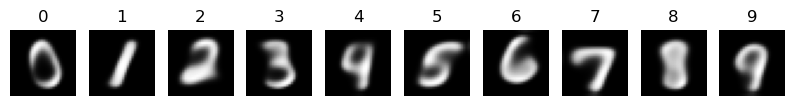

Epoch [2/5], Loss: 1.8550


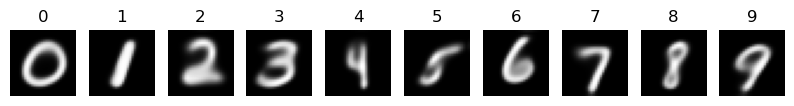

Epoch [3/5], Loss: -0.1203


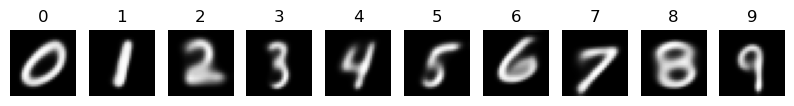

Epoch [4/5], Loss: -1.2014


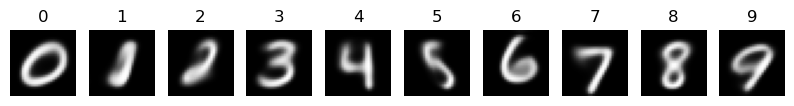

Epoch [5/5], Loss: -1.5260


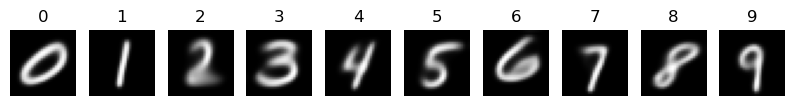

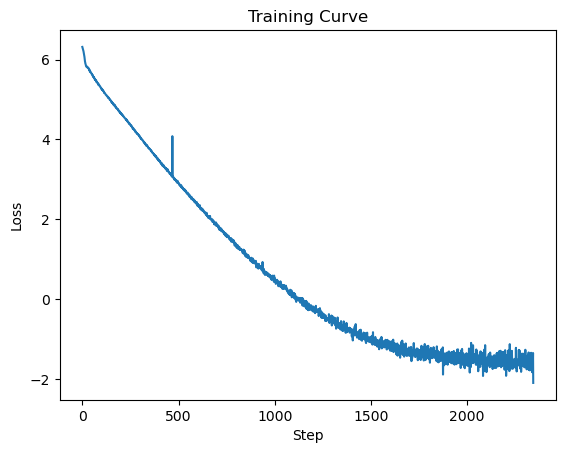

In [71]:
model = training_routine()

# Task 2: Visualize the latent space

In [73]:
def visualize_latent_space(model, loss_name ): 
  latent_variables = []
  labels = []
  dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=True)

  for x, y in dataloader_test:
    labels.append(y[0].detach().numpy().flatten().flatten())
    x = x.to(device)
    y = y.to(device)
    z = model.sample_latent(x, y)
    latent_variables.append(z.cpu().detach().numpy().flatten().flatten())
  labels = [label[0] for label in labels]

  # Visualize latent space
  latent_variables = np.array(latent_variables)
  unique_labels = np.unique(labels)

  plt.figure(figsize=(10, 7))

  # Create a scatter plot for each unique label
  for label in unique_labels:
      mask = labels == label
      plt.scatter(latent_variables[mask, 0], latent_variables[mask, 1], label=label, alpha=0.5, s=10)
  plt.title(f"Latent space visualization for {loss_name}")
  plt.legend(title='Numbers')
  plt.show()

Epoch [1/5], Loss: 4.4801


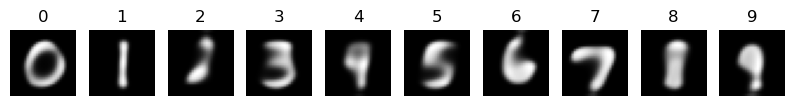

Epoch [2/5], Loss: 1.8863


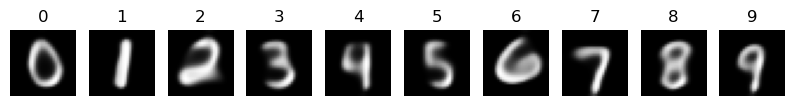

Epoch [3/5], Loss: -0.0908


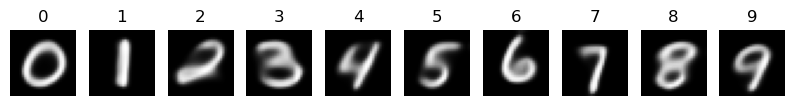

Epoch [4/5], Loss: -1.1789


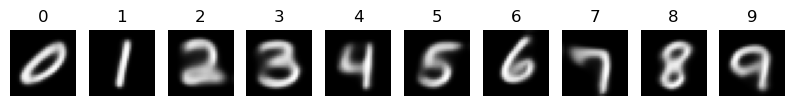

Epoch [5/5], Loss: -1.5082


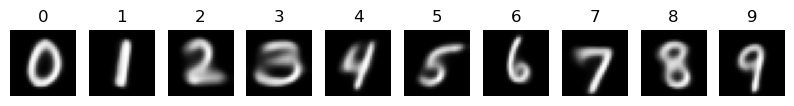

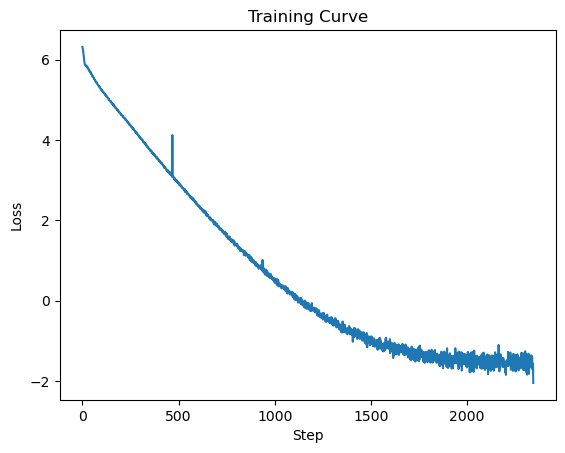

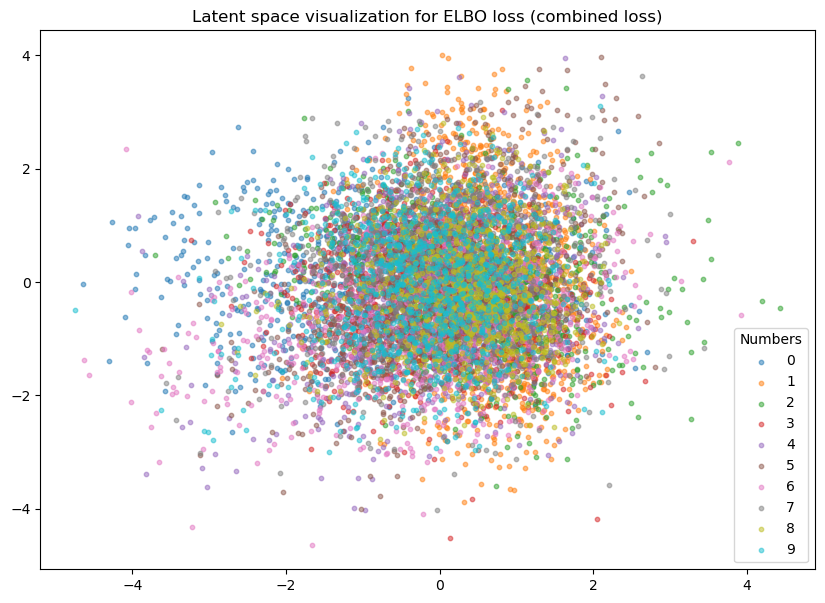

In [74]:
elbo_model = training_routine()
visualize_latent_space(elbo_model, "ELBO loss (combined loss) 1")

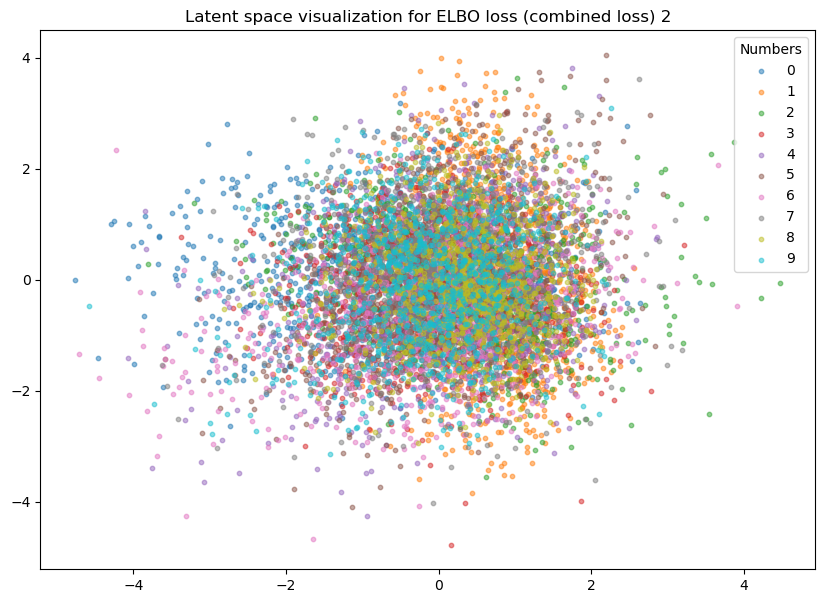

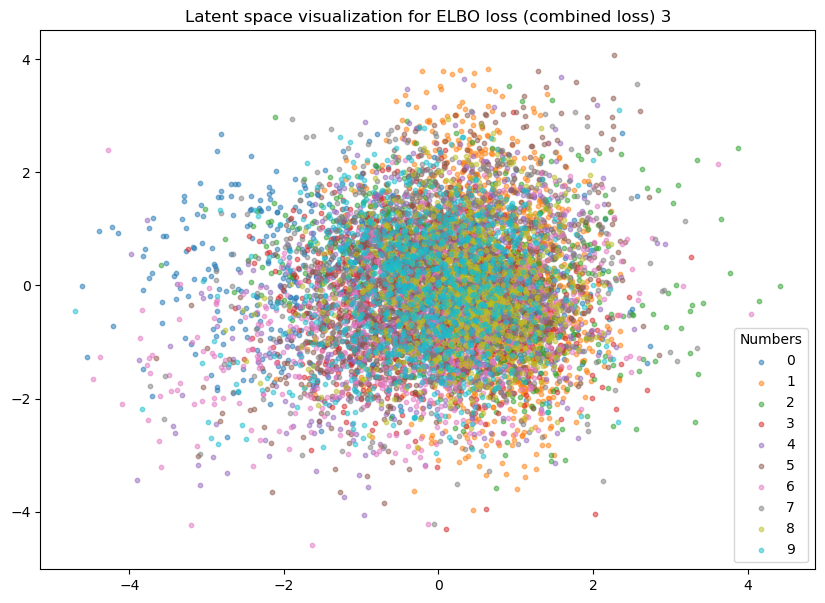

In [78]:
visualize_latent_space(elbo_model, "ELBO loss (combined loss) 2")
visualize_latent_space(elbo_model, "ELBO loss (combined loss) 3")

Epoch [1/5], Loss: 4.4688


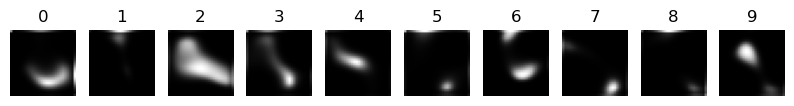

Epoch [2/5], Loss: 1.8482


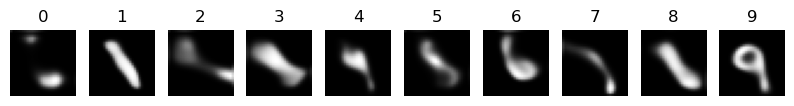

Epoch [3/5], Loss: -0.1192


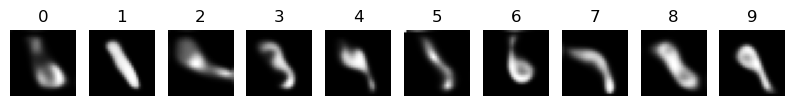

Epoch [4/5], Loss: -1.1899


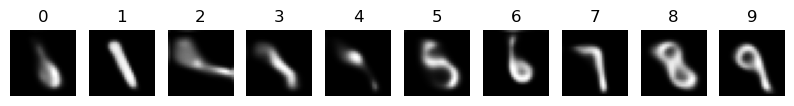

Epoch [5/5], Loss: -1.5142


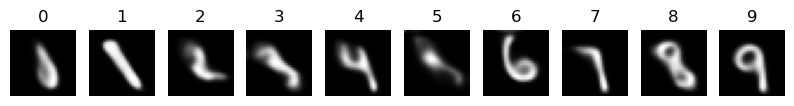

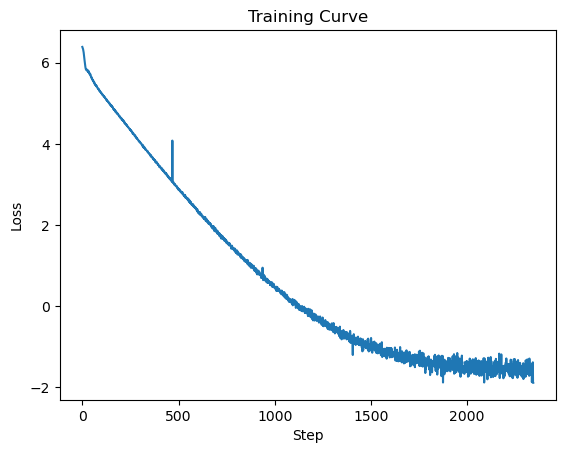

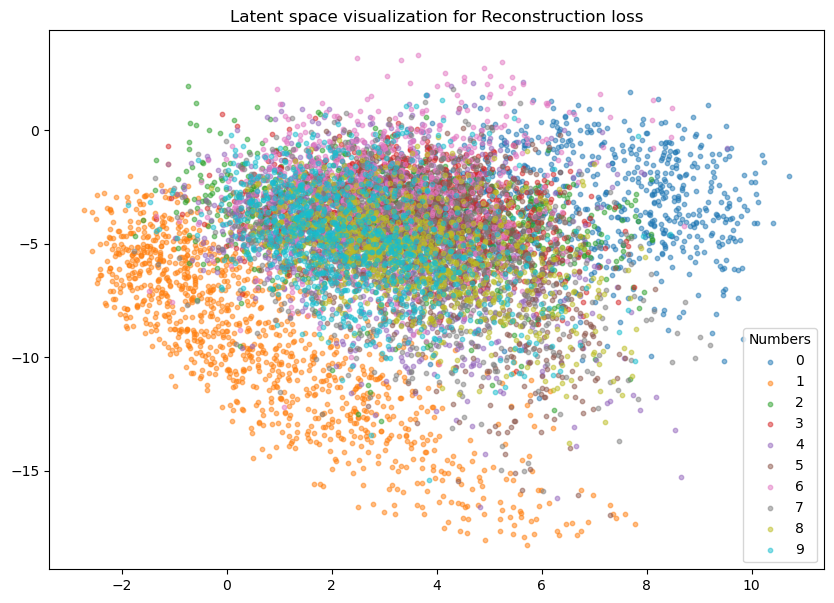

In [75]:
recon_model = training_routine(loss_function="recon")
visualize_latent_space(recon_model, "Reconstruction loss")

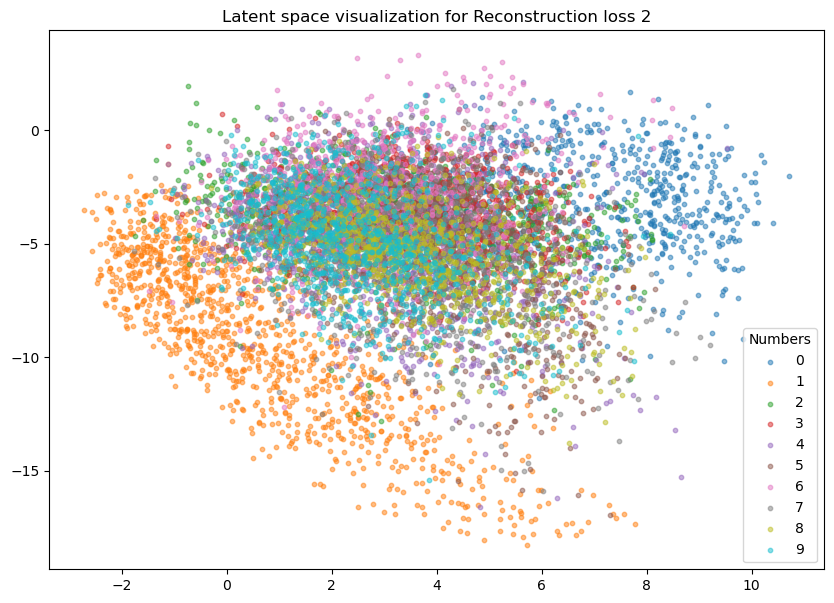

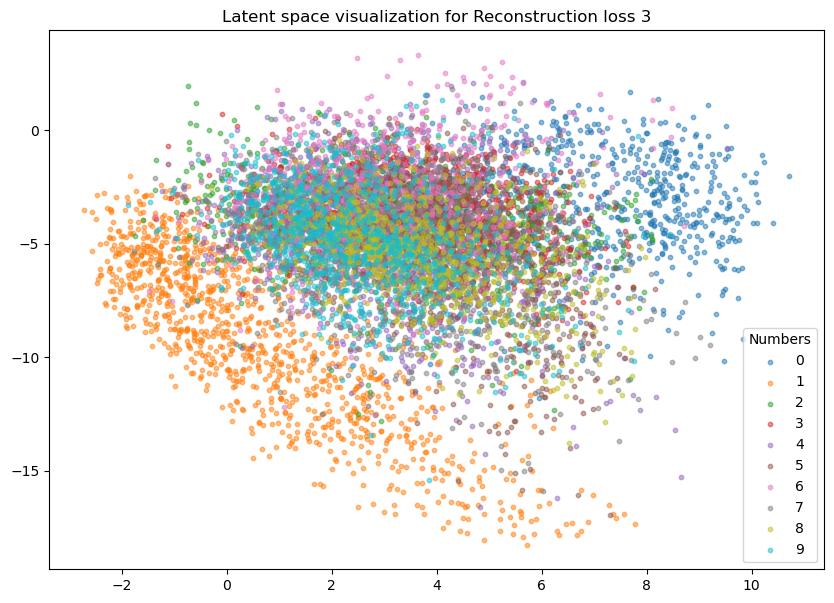

In [79]:
visualize_latent_space(recon_model, "Reconstruction loss 2")
visualize_latent_space(recon_model, "Reconstruction loss 3")

Epoch [1/5], Loss: 0.0017


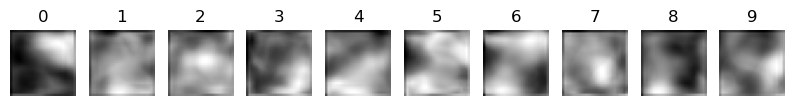

Epoch [2/5], Loss: 0.0012


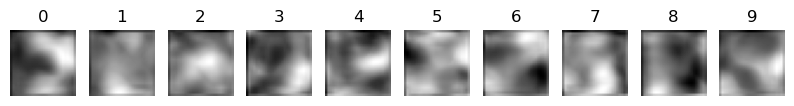

Epoch [3/5], Loss: 0.0012


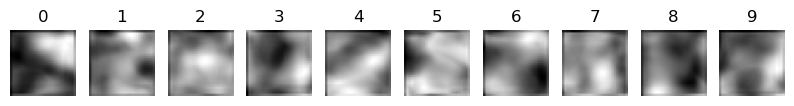

Epoch [4/5], Loss: 0.0010


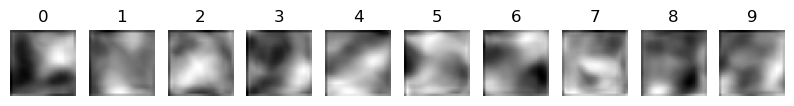

Epoch [5/5], Loss: 0.0011


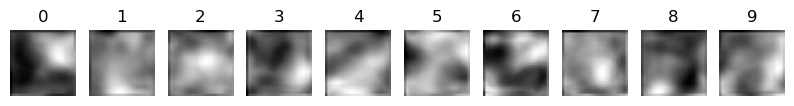

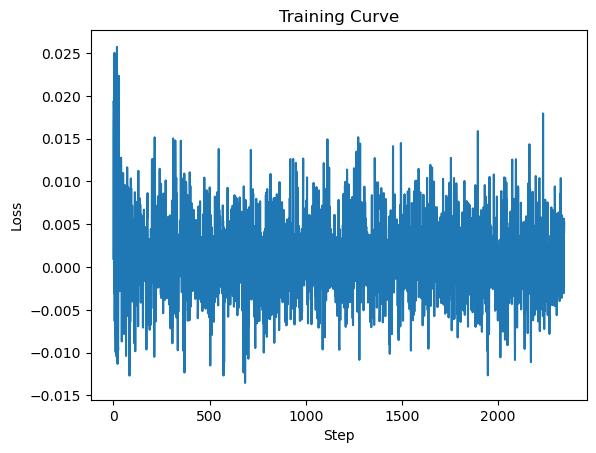

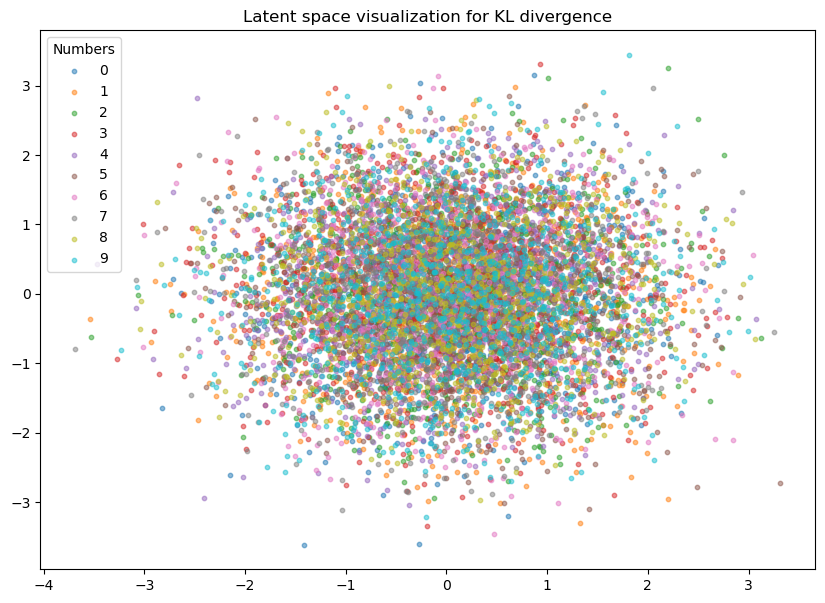

In [76]:
kl_model = training_routine(loss_function="kl")

visualize_latent_space(kl_model, "KL divergence")

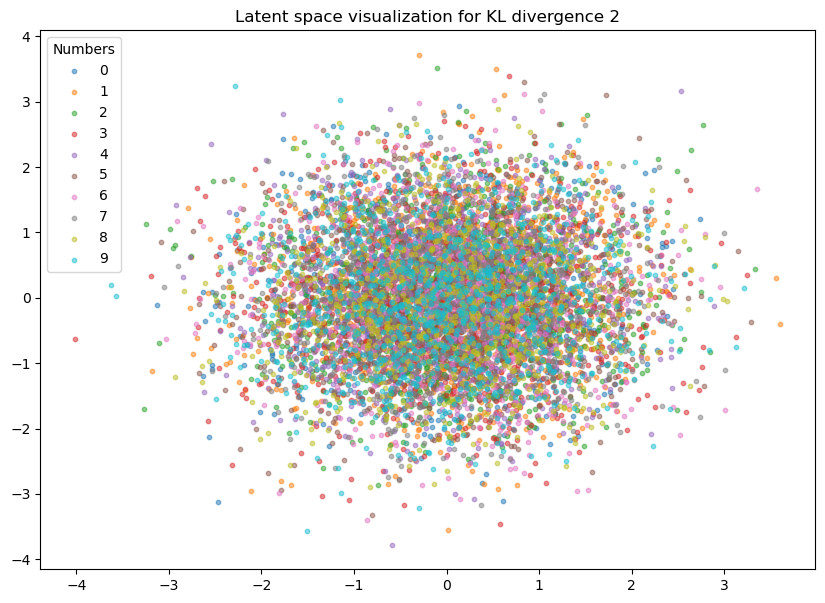

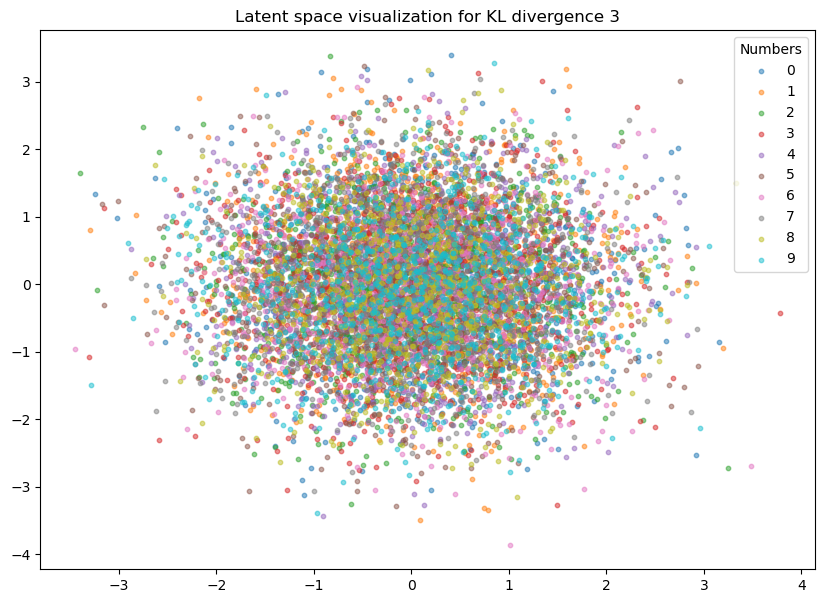

In [80]:
visualize_latent_space(kl_model, "KL divergence 2")
visualize_latent_space(kl_model, "KL divergence 3")

# Task 3: Anomaly Detection using a Variational Autoencoder

c:\Users\adria\anaconda3\envs\genai\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/5], Loss: 4.4770


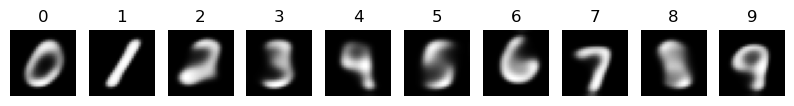

Epoch [2/5], Loss: 1.8787


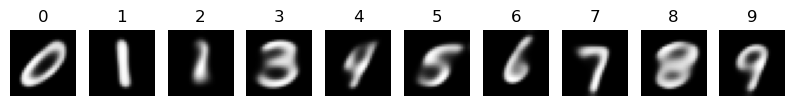

Epoch [3/5], Loss: -0.0822


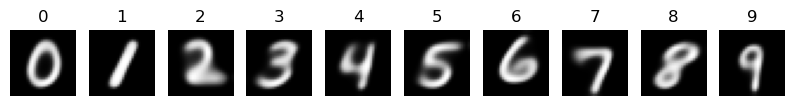

Epoch [4/5], Loss: -1.1610


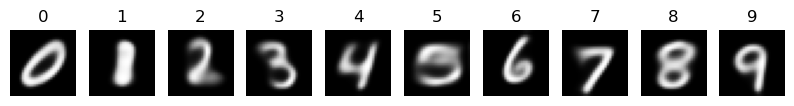

Epoch [5/5], Loss: -1.4877


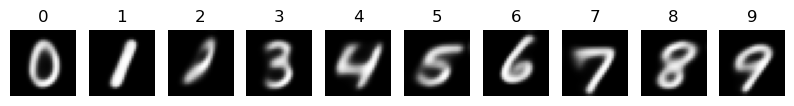

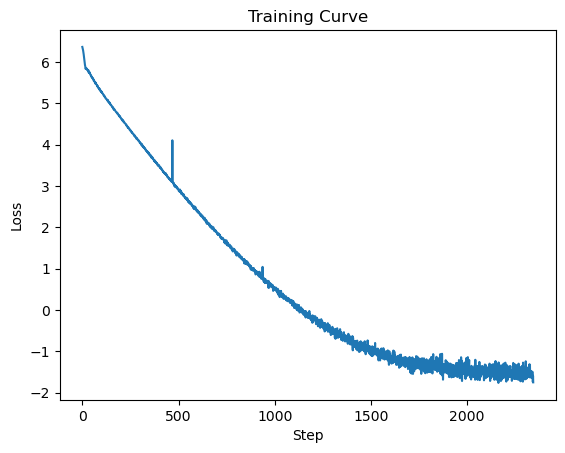

In [8]:
model_task3 = training_routine(num_epochs=5)

In [9]:
fashion_dataset_train = FashionMNIST('./data', train=True, download=True, transform=transform)

C:\Users\adria\AppData\Local\Temp\ipykernel_8136\2371798454.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\adria\AppData\Local\Temp\ipykernel_8136\2371798454.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


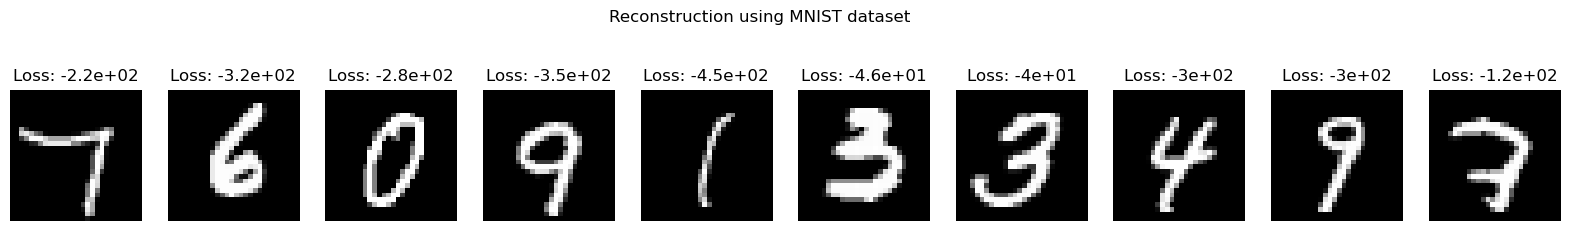

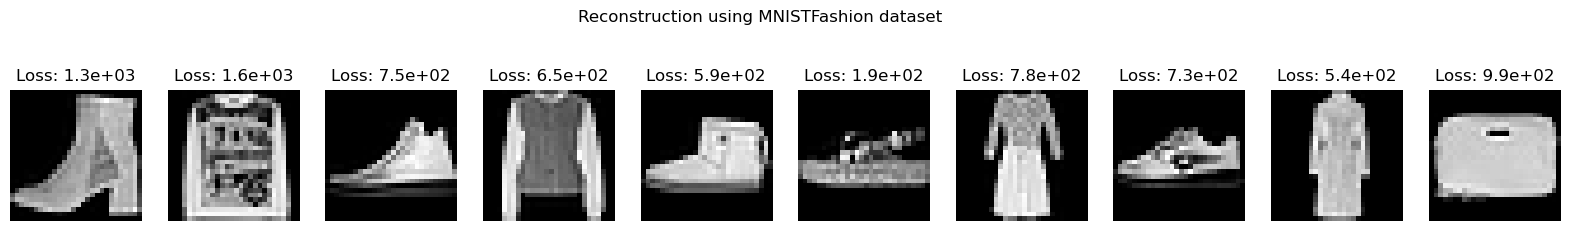

In [11]:
dataloader_train3_fashion = DataLoader(fashion_dataset_train, batch_size=1, shuffle=True)
dataloader_train3 = DataLoader(dataset_train, batch_size=1, shuffle=True)


model_task3.eval()
with torch.no_grad():

  fig, axs = plt.subplots(1,10, figsize=(20,3))

  for i, sample in enumerate(dataloader_train3):
    x = sample[0].to(device)
    y = sample[1].to(device)
    x_recon, mean, log_var = model_task3.forward(x, y)
    loss = elbo_loss(x_recon, x, mean, log_var, kl_weight, model_task3.logscale)

    axs[i].imshow(sample[0].squeeze(), cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f"Loss: {loss:.2}")
    if i == 9:
      break
  fig.suptitle("Reconstruction using MNIST dataset")
  fig.show()

  
  fig, axs = plt.subplots(1, 10, figsize=(20,3))
  for i, sample in enumerate(dataloader_train3_fashion):
    x = sample[0].to(device)
    y = sample[1].to(device)
    x_recon, mean, log_var = model_task3.forward(x, y)
    loss = elbo_loss(x_recon, x, mean, log_var, kl_weight, model_task3.logscale)

    axs[i].imshow(sample[0].squeeze(), cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f"Loss: {loss:4.2}")
    if i == 9:
      break
    fig.suptitle("Reconstruction using MNISTFashion dataset")
    fig.show()



The loss is usually way higher when using the MNISTFashion dataset. Thus, this model can be used for anomaly detection

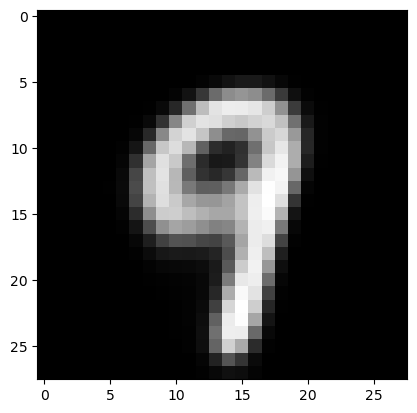

In [20]:
sample = model_task3.sample(torch.tensor(9), device).cpu().detach().numpy()
plt.imshow(sample.squeeze(), cmap='gray')